#Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

In [2]:
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip',sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.replace('?',np.nan,inplace=True)

In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   2075259 non-null  object 
 1   Time                   2075259 non-null  object 
 2   Global_active_power    2049280 non-null  object 
 3   Global_reactive_power  2049280 non-null  object 
 4   Voltage                2049280 non-null  object 
 5   Global_intensity       2049280 non-null  object 
 6   Sub_metering_1         2049280 non-null  object 
 7   Sub_metering_2         2049280 non-null  object 
 8   Sub_metering_3         2049280 non-null  float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


#Pre-Processing Data

House hold consumption = global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3

In [6]:
df['Global_active_power']=df['Global_active_power'].astype('float')
df['Sub_metering_1']=df['Sub_metering_1'].astype('float')
df['Sub_metering_2']=df['Sub_metering_2'].astype('float')
df['Sub_metering_3']=df['Sub_metering_3'].astype('float')

In [7]:
df['consumption']=df['Global_active_power'].apply(lambda x:x*1000/60)-df['Sub_metering_1']-df['Sub_metering_2']-df['Sub_metering_3']
df['consumption']

0          52.266667
1          72.333333
2          70.566667
3          71.800000
4          43.100000
             ...    
2075254    15.766667
2075255    15.733333
2075256    15.633333
2075257    15.566667
2075258    15.533333
Name: consumption, Length: 2075259, dtype: float64

In [8]:
df1=df[['Date','Time','consumption']]
df1

,Date,Time,consumption
0,16/12/2006,17:24:00,52.266667
1,16/12/2006,17:25:00,72.333333
2,16/12/2006,17:26:00,70.566667
3,16/12/2006,17:27:00,71.800000
4,16/12/2006,17:28:00,43.100000
...,...,...,...
2075254,26/11/2010,20:58:00,15.766667
2075255,26/11/2010,20:59:00,15.733333
2075256,26/11/2010,21:00:00,15.633333
2075257,26/11/2010,21:01:00,15.566667


In [9]:
a=[]
b=[]
for i,j in df1.groupby('Date'):
  a.append(i)
  b.append(sum(j['consumption']))

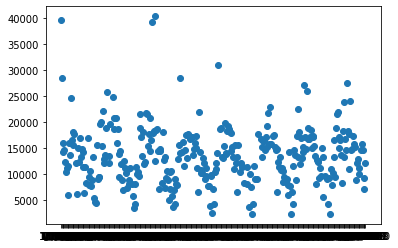

In [10]:
plt.scatter(a[:365],b[:365])

In [11]:
aa=[]
for i in a:
  date_object = datetime.strptime(i, '%d/%m/%Y').date()
  aa.append(date_object)
d=dict(zip(aa,b))
d1=dict(sorted(d.items()))
x=list(d1.keys())
y=list(d1.values())

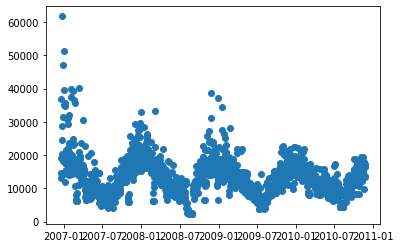

In [12]:
plt.scatter(x,y)

By looking at the data we can use it to predict daily household consumption. 


Lets fill the missing values by last year's same date

In [13]:
df2=pd.DataFrame(data=list(zip(x,y)),columns=['Date','consumption'])
df2

,Date,consumption
0,2006-12-16,14680.933333
1,2006-12-17,36946.666667
2,2006-12-18,19028.433333
3,2006-12-19,13131.900000
4,2006-12-20,20384.800000
...,...,...
1437,2010-11-22,16924.600000
1438,2010-11-23,16352.266667
1439,2010-11-24,13769.466667
1440,2010-11-25,17278.733333


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1442 non-null   object 
 1   consumption  1360 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.7+ KB


#Model 1

Create lagged features and apply Deep Neural Network

##Create lagged features 

In [15]:
def create_features(df):
  df['Year'] = pd.to_datetime(df['Date']).dt.year
  df['Month'] = pd.to_datetime(df['Date']).dt.month
  df['Day'] = pd.to_datetime(df['Date']).dt.day
  df['Dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
  df['DayOfyear'] = pd.to_datetime(df['Date']).dt.dayofyear
  df['Week'] = pd.to_datetime(df['Date']).dt.week
  df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter 
  df['Is_weekend'] = np.where(df['Date'].isin([5,6]),1,0)
  df['Is_weekday'] = np.where(df['Date'].isin([0,1,2,3,4]),1,0)
  return df

In [16]:
df2=create_features(df2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [17]:
df2

,Date,consumption,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_weekend,Is_weekday
0,2006-12-16,14680.933333,2006,12,16,5,350,50,4,0,0
1,2006-12-17,36946.666667,2006,12,17,6,351,50,4,0,0
2,2006-12-18,19028.433333,2006,12,18,0,352,51,4,0,0
3,2006-12-19,13131.900000,2006,12,19,1,353,51,4,0,0
4,2006-12-20,20384.800000,2006,12,20,2,354,51,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1437,2010-11-22,16924.600000,2010,11,22,0,326,47,4,0,0
1438,2010-11-23,16352.266667,2010,11,23,1,327,47,4,0,0
1439,2010-11-24,13769.466667,2010,11,24,2,328,47,4,0,0
1440,2010-11-25,17278.733333,2010,11,25,3,329,47,4,0,0


##Fill Missing values

In [18]:
ref=df2[df2.consumption.isnull()].copy()

In [19]:
ref

,Date,consumption,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_weekend,Is_weekday
5,2006-12-21,NaN,2006,12,21,3,355,51,4,0,0
14,2006-12-30,NaN,2006,12,30,5,364,52,4,0,0
29,2007-01-14,NaN,2007,1,14,6,14,2,1,0,0
43,2007-01-28,NaN,2007,1,28,6,28,4,1,0,0
68,2007-02-22,NaN,2007,2,22,3,53,8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1379,2010-09-25,NaN,2010,9,25,5,268,38,3,0,0
1380,2010-09-26,NaN,2010,9,26,6,269,38,3,0,0
1381,2010-09-27,NaN,2010,9,27,0,270,39,3,0,0
1382,2010-09-28,NaN,2010,9,28,1,271,39,3,0,0


In [20]:
ref['Date'].index


Int64Index([   5,   14,   29,   43,   68,   99,  133,  134,  135,  167,  172,
             175,  185,  195,  211,  218,  228,  251,  284,  311,  340,  348,
             366,  393,  413,  434,  464,  517,  545,  575,  597,  624,  679,
             695,  697,  708,  725,  735,  760,  778,  791,  794,  806,  821,
             849,  876,  892,  910,  911,  912,  937,  971, 1002, 1019, 1030,
            1059, 1090, 1113, 1123, 1124, 1125, 1134, 1152, 1156, 1190, 1191,
            1212, 1244, 1274, 1291, 1307, 1340, 1341, 1342, 1343, 1344, 1345,
            1379, 1380, 1381, 1382, 1408],
           dtype='int64')

In [21]:
def fill_na(df,ref):
  for i in ref['Date']:
    x=ref[ref['Date']==i]['DayOfyear'].tolist()[0]
    a=df[df['DayOfyear']==x]['consumption'].mean()
    ind=ref['Date'][ref['Date'] == i].index[0]
    df.loc[ind,'consumption']=a
  return df
df2=fill_na(df2,ref)

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1442 non-null   object 
 1   consumption  1442 non-null   float64
 2   Year         1442 non-null   int64  
 3   Month        1442 non-null   int64  
 4   Day          1442 non-null   int64  
 5   Dayofweek    1442 non-null   int64  
 6   DayOfyear    1442 non-null   int64  
 7   Week         1442 non-null   int64  
 8   Quarter      1442 non-null   int64  
 9   Is_weekend   1442 non-null   int64  
 10  Is_weekday   1442 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 124.0+ KB


In [23]:
#plt.scatter(df['Date'],df['consumption'])

##Build DNN

perform label encodeing


In [24]:
df2.head()

,Date,consumption,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_weekend,Is_weekday
0,2006-12-16,14680.933333,2006,12,16,5,350,50,4,0,0
1,2006-12-17,36946.666667,2006,12,17,6,351,50,4,0,0
2,2006-12-18,19028.433333,2006,12,18,0,352,51,4,0,0
3,2006-12-19,13131.900000,2006,12,19,1,353,51,4,0,0
4,2006-12-20,20384.800000,2006,12,20,2,354,51,4,0,0


In [25]:
le = preprocessing.LabelEncoder()
df2['Year']=le.fit_transform(df2['Year'])
df2['date']=le.fit_transform(df2['Date'])

###Building model with single node 

In [72]:
x=df2[['date','Year','Month','Day','Dayofweek','DayOfyear','Week','Quarter','Is_weekend','Is_weekday']].to_numpy()
y=df2['consumption'].to_numpy()

xtrn,ytrn=x[:-80],y[:-80]
xtst,ytst=x[-80:],y[-80:]

In [73]:
opt=tf.keras.optimizers.Adam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)

In [74]:
layer=tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(10,))
outputs=layer(inputs)

model=tf.keras.Model(inputs=inputs, outputs=outputs)

In [75]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_absolute_error')

In [77]:
model.fit(xtrn,ytrn,batch_size=128,epochs=5000)

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 0s 3ms/step - loss: 43141928.0000 - mean_absolute_error: 4942.6055
Epoch 2502/5000
11/11 [==============================] - 0s 4ms/step - loss: 43138036.0000 - mean_absolute_error: 4944.3081
Epoch 2503/5000
11/11 [==============================] - 0s 3ms/step - loss: 43118696.0000 - mean_absolute_error: 4941.5229
Epoch 2504/5000
11/11 [==============================] - 0s 2ms/step - loss: 43133460.0000 - mean_absolute_error: 4940.4600
Epoch 2505/5000
11/11 [==============================] - 0s 3ms/step - loss: 43136472.0000 - mean_absolute_error: 4944.9966
Epoch 2506/5000
11/11 [==============================] - 0s 3ms/step - loss: 43139384.0000 - mean_absolute_error: 4944.4214
Epoch 2507/5000
11/11 [==============================] - 0s 4ms/step - loss: 43114520.0000 - mean_absolute_error: 4941.1787
Epoch 2508/5000
11/11 [==============================] - 0s 3ms/step - loss: 43115120.0000 - mean

In [82]:
def eva(model,xtst,ytst):
  ypred=model.predict(xtst)
  ypred=ypred.reshape(ypred.shape[0])
  error=mean_absolute_error(ytst, ypred)
  print('Mean absolute error is:{}\nPrediction plot:'.format(error))
  plt.plot(range(len(ypred)),ypred)
  plt.plot(range(len(ypred)),ytst)
  plt.legend(["Predicted", "Actual"], loc ="upper left")
  plt.xlabel("Dates")
  plt.ylabel("Daily Consumption")
  plt.show()


Mean absolute error is:3069.49022298177
Prediction plot:


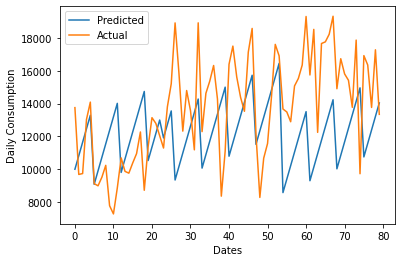

In [83]:
eva(model,xtst,ytst)

### Use Dummy variables (One hot encoding)

In [84]:
en=OneHotEncoder(sparse=False)
xx=en.fit_transform(x[:,1:])

xtrn,ytrn=xx[:-80],y[:-80]
xtst,ytst=xx[-80:],y[-80:]

In [85]:
layer=tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(480,))
outputs=layer(inputs)

model=tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 480)]             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 481       
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_absolute_error')
model.fit(xtrn,ytrn,batch_size=128,epochs=5000)

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 0s 3ms/step - loss: 15515329.0000 - mean_absolute_error: 2424.6475
Epoch 2502/5000
11/11 [==============================] - 0s 3ms/step - loss: 15511908.0000 - mean_absolute_error: 2424.4243
Epoch 2503/5000
11/11 [==============================] - 0s 3ms/step - loss: 15508364.0000 - mean_absolute_error: 2424.1919
Epoch 2504/5000
11/11 [==============================] - 0s 3ms/step - loss: 15504828.0000 - mean_absolute_error: 2423.8862
Epoch 2505/5000
11/11 [==============================] - 0s 3ms/step - loss: 15501380.0000 - mean_absolute_error: 2423.6343
Epoch 2506/5000
11/11 [==============================] - 0s 3ms/step - loss: 15497744.0000 - mean_absolute_error: 2423.4355
Epoch 2507/5000
11/11 [==============================] - 0s 3ms/step - loss: 15494323.0000 - mean_absolute_error: 2423.2019
Epoch 2508/5000
11/11 [==============================] - 0s 3ms/step - loss: 15490926.0000 - mean

Mean absolute error is:2012.8911924913177
Prediction plot:


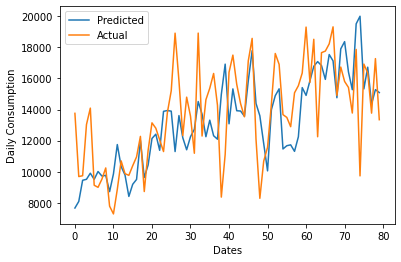

In [87]:
eva(model,xtst,ytst)

### Deep Neural Network

Model Params
No of Layers:4   Nodes:[128, 64, 16, 1]
Mean absolute error is:4950.351930474176
Prediction plot:


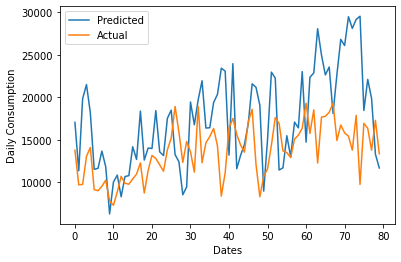




Model Params
No of Layers:5   Nodes:[100, 64, 32, 4, 1]
Mean absolute error is:3785.5191146511474
Prediction plot:


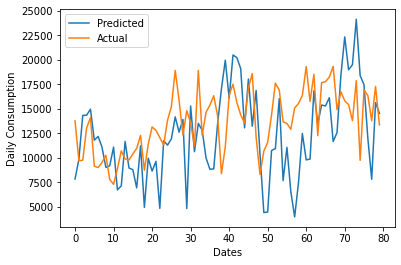




Model Params
No of Layers:3   Nodes:[64, 16, 1]
Mean absolute error is:3507.031428900824
Prediction plot:


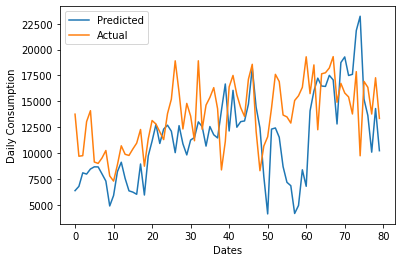




Model Params
No of Layers:3   Nodes:[32, 4, 1]
Mean absolute error is:3177.6830379231765
Prediction plot:


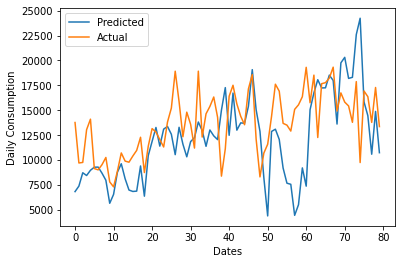




Model Params
No of Layers:5   Nodes:[64, 32, 16, 4, 1]
Mean absolute error is:3149.1948339843743
Prediction plot:


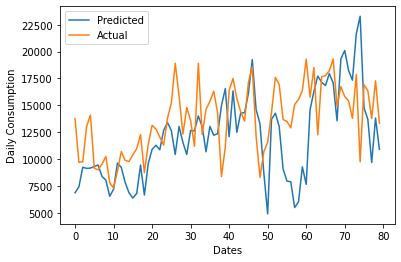

In [88]:
params=[[128,64,16,1],[100,64,32,4,1],[64,16,1],[32,4,1],[64,32,16,4,1]]

for p in params:
  tf.keras.backend.clear_session()
  n=len(p)
  inputs = tf.keras.Input(shape=(480,))
  for i in range(n-1):
    if i==0:
      l=tf.keras.layers.Dense(p[0])(inputs)
    l=tf.keras.layers.Dense(p[i])(l)
  outputs=tf.keras.layers.Dense(1)(l)
  model=tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_absolute_error')
  h=model.fit(xtrn,ytrn,batch_size=128,epochs=5000,verbose=False)
  #model.compile(optimizer='adam',loss=loss,metrics=['accuracy','AUC'])
  #h=model.fit(xtrn,ytrn,batch_size=128,epochs=1000,validation_data=(xval,yval),verbose=False)
  print('Model Params\nNo of Layers:{}   Nodes:{}'.format(n,p))
  eva(model,xtst,ytst)
  print('\n\n')

### DNN with activations

Model Params
No of Layers:4   Nodes:[128, 64, 16, 1]
Mean absolute error is:4488.923860812718
Prediction plot:


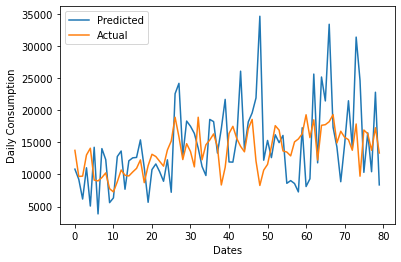




Model Params
No of Layers:5   Nodes:[100, 64, 32, 4, 1]
Mean absolute error is:8125.109053819442
Prediction plot:


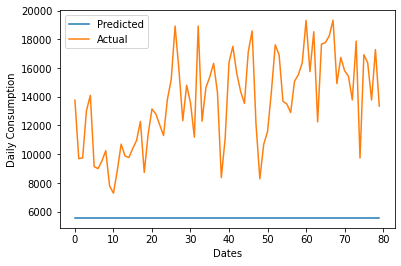




Model Params
No of Layers:3   Nodes:[64, 16, 1]
Mean absolute error is:2755.067617865666
Prediction plot:


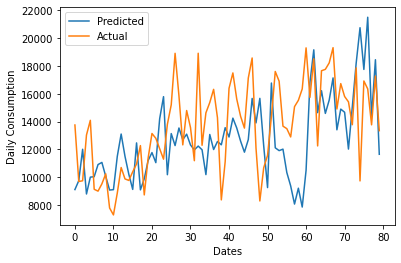




Model Params
No of Layers:3   Nodes:[32, 4, 1]
Mean absolute error is:8128.799971788192
Prediction plot:


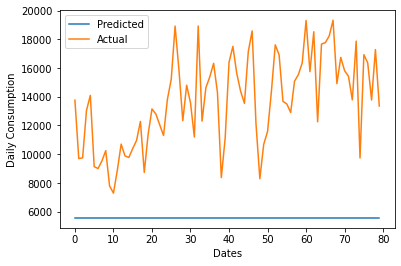




Model Params
No of Layers:5   Nodes:[64, 32, 16, 4, 1]
Mean absolute error is:8126.713057725692
Prediction plot:


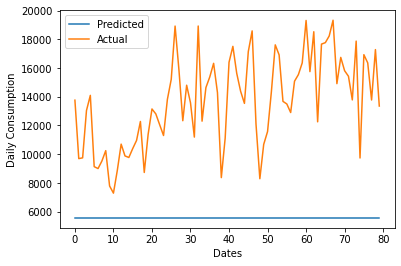

In [90]:
params=[[128,64,16,1],[100,64,32,4,1],[64,16,1],[32,4,1],[64,32,16,4,1]]
loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=True, label_smoothing=0.0, axis=-1)
for p in params:
  tf.keras.backend.clear_session()
  n=len(p)
  inputs = tf.keras.Input(shape=(480,))
  for i in range(n-1):
    if i==0:
      l=tf.keras.layers.Dense(p[0],activation='relu')(inputs)
    l=tf.keras.layers.Dense(p[i],activation='relu')(l)
  outputs=tf.keras.layers.Dense(1)(l)
  model=tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_absolute_error')
  h=model.fit(xtrn,ytrn,batch_size=128,epochs=5000,verbose=False)
  #model.compile(optimizer='adam',loss=loss,metrics=['accuracy','AUC'])
  #h=model.fit(xtrn,ytrn,batch_size=128,epochs=1000,validation_data=(xval,yval),verbose=False)
  print('Model Params\nNo of Layers:{}   Nodes:{}'.format(n,p))
  eva(model,xtst,ytst)
  print('\n\n')

# Model 2

Use CNN and Wavenet 

## Prepare a uni-variate dataset 

In [91]:
df3=df2['consumption']

In [92]:
df3

0       14680.933333
1       36946.666667
2       19028.433333
3       13131.900000
4       20384.800000
            ...     
1437    16924.600000
1438    16352.266667
1439    13769.466667
1440    17278.733333
1441    13347.733333
Name: consumption, Length: 1442, dtype: float64

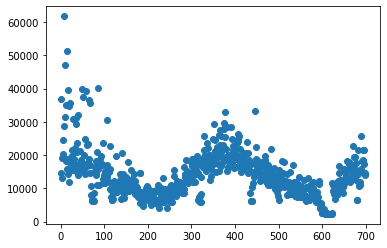

In [93]:
plt.scatter(range(700),df3[:700])

In [94]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [95]:
x,y=split_sequence(df3.tolist(),80)

In [96]:
xtrn,ytrn=x[:-80],y[:-80]
xtst,ytst=x[-80:],y[-80:]

##Build CNN model

In [145]:
inputs = tf.keras.Input(shape=(80,1))
conv1=tf.keras.layers.Conv1D(128,32,activation='relu',padding='same')(inputs)
max1=tf.keras.layers.MaxPool1D(4)(conv1)
flatten=tf.keras.layers.Flatten()(max1)
dense1=tf.keras.layers.Dense(50)(flatten)
outputs=tf.keras.layers.Dense(1)(dense1)

model=tf.keras.Model(inputs,outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 128)           4224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 128)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_10 (Dense)            (None, 50)                128050    
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                           

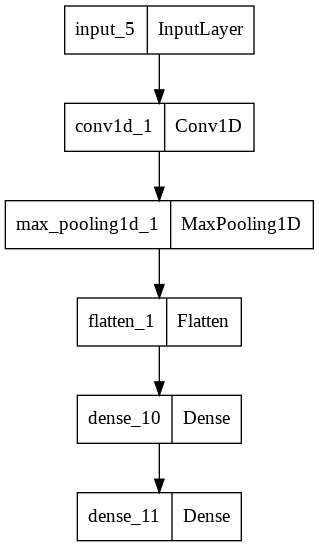

In [146]:
tf.keras.utils.plot_model(model)

In [98]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics='mean_absolute_error')

In [99]:
xtrn = xtrn.reshape((xtrn.shape[0], xtrn.shape[1], 1))
xtst = xtst.reshape((xtst.shape[0], xtst.shape[1], 1))

In [100]:
#model.fit(xtrn,ytrn,epochs=1000)
model.fit(xtrn,ytrn,batch_size=128,epochs=5000)

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 1s 57ms/step - loss: 1258294.5000 - mean_absolute_error: 876.9845
Epoch 2502/5000
11/11 [==============================] - 1s 59ms/step - loss: 1002924.5000 - mean_absolute_error: 767.8248
Epoch 2503/5000
11/11 [==============================] - 1s 54ms/step - loss: 1550499.7500 - mean_absolute_error: 975.8058
Epoch 2504/5000
11/11 [==============================] - 1s 58ms/step - loss: 1334616.5000 - mean_absolute_error: 909.2433
Epoch 2505/5000
11/11 [==============================] - 1s 49ms/step - loss: 1063165.1250 - mean_absolute_error: 797.4130
Epoch 2506/5000
11/11 [==============================] - 1s 49ms/step - loss: 931671.1875 - mean_absolute_error: 738.9587
Epoch 2507/5000
11/11 [==============================] - 1s 60ms/step - loss: 881468.1875 - mean_absolute_error: 713.0001
Epoch 2508/5000
11/11 [==============================] - 1s 59ms/step - loss: 942090.1875 - mean_absolute_

Mean absolute error is:2915.687479926216
Prediction plot:


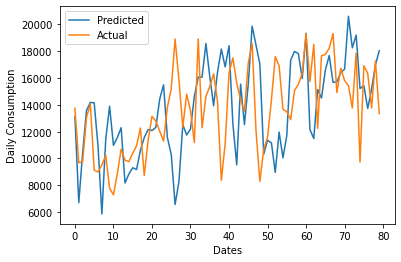

In [102]:
eva(model,xtst,ytst)

#Consuming the Best model

In [117]:
x=df2[['date','Year','Month','Day','Dayofweek','DayOfyear','Week','Quarter','Is_weekend','Is_weekday']].to_numpy()
y=df2['consumption'].to_numpy()

en=OneHotEncoder(sparse=False)
x=en.fit_transform(x[:,1:])

layer=tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(480,))
outputs=layer(inputs)
model=tf.keras.Model(inputs=inputs, outputs=outputs)

opt=tf.keras.optimizers.Adam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_absolute_error')
model.fit(x,y,batch_size=128,epochs=5000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 3ms/step - loss: 22035282.0000 - mean_absolute_error: 3003.0955
Epoch 1621/5000
12/12 [==============================] - 0s 3ms/step - loss: 22018094.0000 - mean_absolute_error: 3001.7808
Epoch 1622/5000
12/12 [==============================] - 0s 3ms/step - loss: 22002098.0000 - mean_absolute_error: 3000.5173
Epoch 1623/5000
12/12 [==============================] - 0s 4ms/step - loss: 21984836.0000 - mean_absolute_error: 2999.1235
Epoch 1624/5000
12/12 [==============================] - 0s 3ms/step - loss: 21968266.0000 - mean_absolute_error: 2997.7646
Epoch 1625/5000
12/12 [==============================] - 0s 3ms/step - loss: 21951798.0000 - mean_absolute_error: 2996.4871
Epoch 1626/5000
12/12 [==============================] - 0s 3ms/step - loss: 21935144.0000 - mean_absolute_error: 2995.1296
Epoch 1627/5000
12/12 [==============================] - 0s 4ms/step - loss: 21918374.0000 - mean

In [141]:
def predict(numdays):
  base = df2['Date'].iloc[-1]
  date_list = pd.date_range(base, periods=numdays).tolist()
  date_list=[i.date() for i in date_list]
  df=pd.DataFrame(date_list,columns=['Date'])
  df=create_features(df)
  le = preprocessing.LabelEncoder()
  df['Year']=le.fit_transform(df['Year'])
  x=df[['Year','Month','Day','Dayofweek','DayOfyear','Week','Quarter','Is_weekend','Is_weekday']].to_numpy()
  x=en.transform(x)
  ypred=model.predict(x)
  ypred=ypred.reshape(ypred.shape[0])
  n=len(df2)
  t=[n+i for i in range(numdays)]
  plt.plot(range(len(df2)),y)
  plt.plot(t,ypred)
  plt.legend(["Past", "Estimated"], loc ="upper left")
  plt.xlabel("Dates")
  plt.ylabel("Daily Consumption")
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


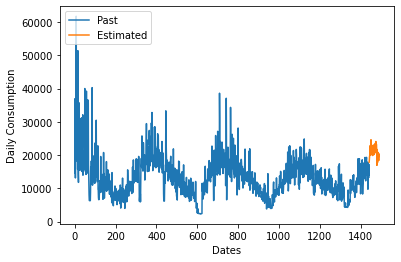

In [142]:
predict(50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


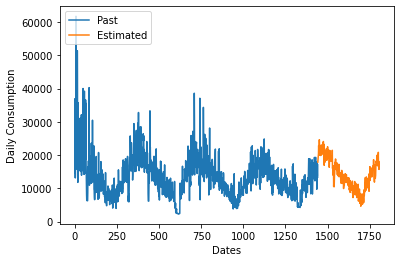

In [143]:
predict(365)

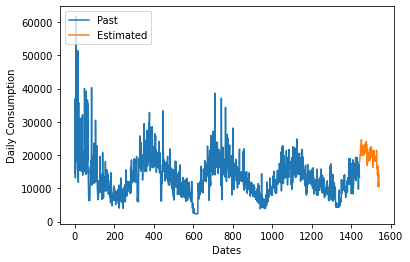

In [139]:
predict(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


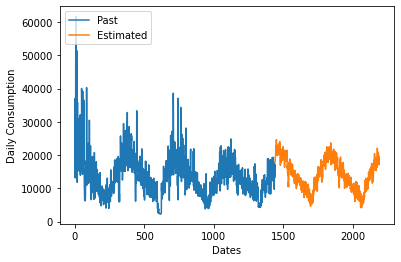

In [144]:
predict(750)